In [54]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [55]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [56]:
from sklearn.datasets import make_classification, make_blobs

In [57]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [58]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## Viz Residual

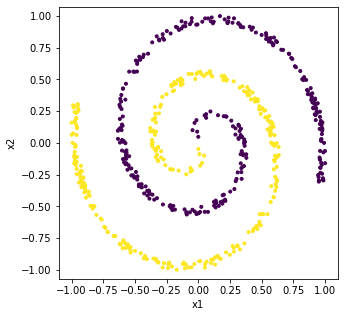

In [59]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [60]:
xx, yy = xx.to(device), yy.to(device)

In [61]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

#### Directional Similarity Based On Gradient Magnitude

In [62]:
def directional_similarity_mag(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [63]:
def directional_similarity_mag_euclidian(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
#     return 1-vecs_mag.squeeze(-1)
    return 1*torch.norm(direction, dim=-1, keepdim=True)-vecs_mag.squeeze(-1)

In [64]:
def directional_similarity_mag_maximum(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    ## Since the maxima is at 1/2th the distance - direction is doubled to manage
    direction = direction*2
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
    
    vecs = other_points.unsqueeze(0) - (point+direction).unsqueeze(1)
    vecs_mag_from_target = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    
    vecs2 = other_points.unsqueeze(0) - (point).unsqueeze(1)
    vecs_mag = torch.norm(vecs2, p=2, dim=-1, keepdim=True)
    vecs_angle_from_source = vecs2/(vecs_mag+1e-11) ## 1e-B for stability
    
    vecs_mag_from_target = torch.maximum(vecs_mag, vecs_mag_from_target)
    
#     vecs_angle_from_source = torch.acos(vecs_angle_from_source)
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_angle_from_source, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag_from_target+1e-11) ## gives inportance to similarity
#     yout = yout*(vecs_mag_from_target) ## gives inportance to similarity
    yout = yout*C

    return yout.squeeze(-1)

In [65]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[0.5, 0.5]])*0.1

In [66]:
num_points = 100

C = 1.3
## get dif in point and dirn
px, py = (point+direction*0.5)[0].tolist()
mag = (direction**2).sum().sqrt()

left = px-mag*C
right = px+mag*C
top = py-mag*C
bottom = py+mag*C


X1 = np.linspace(left, right, num_points)
X2 = np.linspace(top, bottom, num_points)
X1, X2 = np.meshgrid(X1, X2)
XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [67]:
sim = directional_similarity_mag_euclidian(point, direction, XX_grid)
print(sim.max())

tensor(0.0706)


In [68]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([[7.0155e-05, 7.0095e-05]])


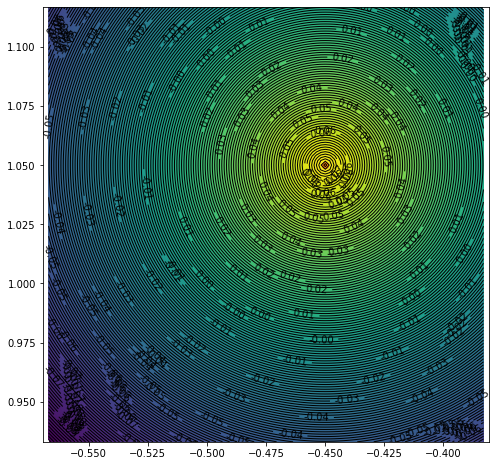

In [69]:
%matplotlib inline
LVLs=200
# LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.scatter(*(point+direction).t())
plt.axis('equal')
print(xx_max-direction-point) ## should give zero for valid maximum


## With Residual Framework

In [242]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransform(2, h),
            nn.BatchNorm1d(h),
#             nn.LayerNorm(h, elementwise_affine=False),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=0.0), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2, bias=False),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1, bias=True)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return self.clf(x + self.net(x))

    def get_pointwise_residual_loss(self, xx):
#         print(self.net[0].centers.shape)
#         print(xx.shape)
        '''
        1)
        c_(given_x) = get closest center for given x (voronoi)
        res = c_i + w_i
        
        OR
        2)
        res = c + w (+b)
        d = cdist(res, x)
        find clsoest x to d and mimimize the distance as loss.
        '''
    
        ### 2)
#         print(self.net[-1].weight.t().shape)
        transf = self.net[0].centers + self.net[-1].weight.t()
#         print("transf", transf.shape)
        dists = torch.cdist(transf, xx)
#         print(dists.shape)
        dists_min = torch.min(dists, dim=0)[0]
#         dists_min = torch.min(dists, dim=1)[0]
        return dists_min.pow(0.5).mean()
    
    def get_pointwise_centeroid_loss(self, xx):
        min_dist = torch.cdist(net.net[0].centers, xx).min(dim=0)[0]
#         min_dist = torch.cdist(net.net[0].centers, xx).min(dim=1)[0]
#         print(min_dist.shape)
        return min_dist.pow(0.5).mean()

In [243]:
ResidualMLP(10, scale=10.0).get_pointwise_residual_loss(xx)

tensor(0.6007, grad_fn=<MeanBackward0>)

In [244]:
ResidualMLP(10, scale=10.0).get_pointwise_centeroid_loss(xx)

tensor(0.5638, grad_fn=<MeanBackward0>)

In [245]:
# yy = yy.reshape(-1, 1)

In [246]:
net = ResidualMLP(10, scale=10.0).to(device)

lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
# LR = 0.01
# min_sim = 0.00 #-500## 0.0

In [247]:
net.net[0].centers.shape, net.net[-1].weight.shape

(torch.Size([10, 2]), torch.Size([2, 10]))

In [248]:
net

ResidualMLP(
  (net): Sequential(
    (0): DistanceTransform()
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): ScaleShift()
      (1): Softmax(dim=-1)
    )
    (3): OneActiv()
    (4): Linear(in_features=10, out_features=2, bias=False)
  )
  (clf): Linear(in_features=2, out_features=1, bias=True)
)

In [249]:
x1.shape, out.shape

(torch.Size([600]), (600, 1))

Epoch: 99, Acc:0.83, Loss:1.3189418315887451
Epoch: 199, Acc:0.98, Loss:1.0482221841812134
Epoch: 299, Acc:0.98, Loss:1.012438416481018
Epoch: 399, Acc:0.98, Loss:0.9941909313201904
Epoch: 499, Acc:0.98, Loss:0.9838852882385254
Epoch: 599, Acc:0.98, Loss:0.9725390672683716
Epoch: 699, Acc:0.98, Loss:0.9604424238204956
Epoch: 799, Acc:0.98, Loss:0.949971616268158
Epoch: 899, Acc:0.98, Loss:0.9464892148971558
Epoch: 999, Acc:0.98, Loss:0.9440608620643616


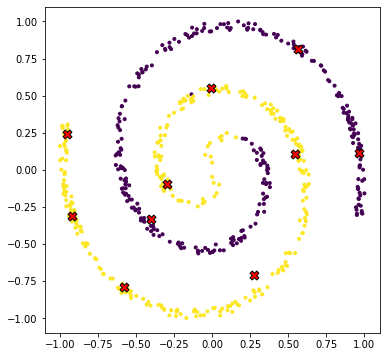

Epoch: 1099, Acc:0.98, Loss:0.9422242641448975
Epoch: 1199, Acc:0.98, Loss:0.9405022859573364
Epoch: 1299, Acc:0.98, Loss:0.93888258934021
Epoch: 1399, Acc:0.98, Loss:0.9377419948577881
Epoch: 1499, Acc:0.98, Loss:0.9370293617248535
Epoch: 1599, Acc:0.98, Loss:0.9362954497337341
Epoch: 1699, Acc:0.98, Loss:0.9356206059455872
Epoch: 1799, Acc:0.98, Loss:0.9352158904075623
Epoch: 1899, Acc:0.98, Loss:0.934796929359436
Epoch: 1999, Acc:0.98, Loss:0.9347314834594727


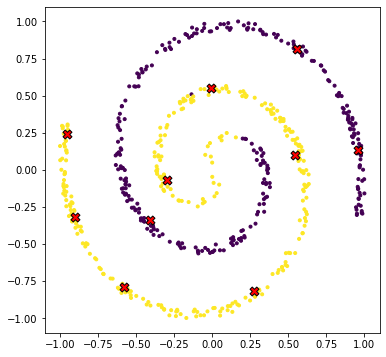

Epoch: 2099, Acc:0.98, Loss:0.9355465173721313
Epoch: 2199, Acc:0.98, Loss:0.9342888593673706
Epoch: 2299, Acc:0.98, Loss:0.9336756467819214
Epoch: 2399, Acc:0.98, Loss:0.9339162111282349
Epoch: 2499, Acc:0.98, Loss:0.9402997493743896
Epoch: 2599, Acc:0.98, Loss:0.9328523874282837
Epoch: 2699, Acc:0.98, Loss:0.9322203993797302
Epoch: 2799, Acc:0.98, Loss:0.9318821430206299
Epoch: 2899, Acc:0.98, Loss:0.931668758392334
Epoch: 2999, Acc:0.98, Loss:0.9314350485801697


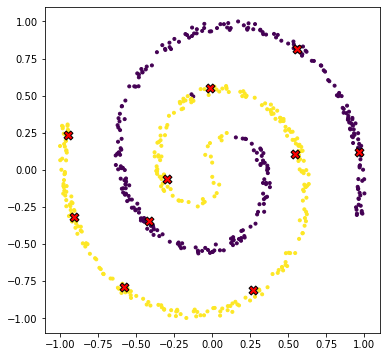

Epoch: 3099, Acc:0.98, Loss:0.9314466714859009
Epoch: 3199, Acc:0.98, Loss:0.9311333894729614
Epoch: 3299, Acc:0.98, Loss:0.9312644004821777
Epoch: 3399, Acc:0.98, Loss:0.931056022644043
Epoch: 3499, Acc:0.98, Loss:0.9310123920440674
Epoch: 3599, Acc:0.98, Loss:0.9310300350189209
Epoch: 3699, Acc:0.98, Loss:0.9310897588729858
Epoch: 3799, Acc:0.98, Loss:0.9310309886932373
Epoch: 3899, Acc:0.98, Loss:0.9308602809906006
Epoch: 3999, Acc:0.98, Loss:0.9308894872665405


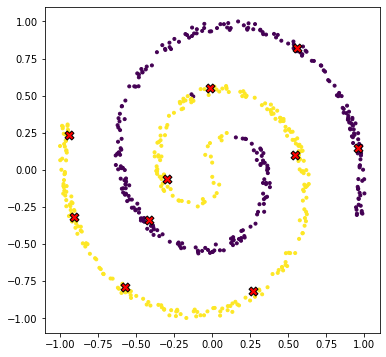

Epoch: 4099, Acc:0.97, Loss:0.9483852386474609
Epoch: 4199, Acc:0.98, Loss:0.9311702847480774
Epoch: 4299, Acc:0.98, Loss:0.9312572479248047
Epoch: 4399, Acc:0.98, Loss:0.93084716796875
Epoch: 4499, Acc:0.98, Loss:0.930966854095459
Epoch: 4599, Acc:0.98, Loss:0.9310449361801147
Epoch: 4699, Acc:0.98, Loss:0.9306474328041077
Epoch: 4799, Acc:0.98, Loss:0.9306420683860779
Epoch: 4899, Acc:0.98, Loss:0.9365029335021973
Epoch: 4999, Acc:0.98, Loss:0.9309667944908142


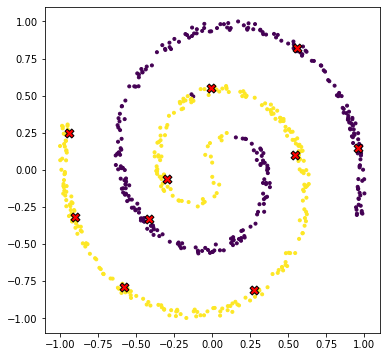

Epoch: 5099, Acc:0.98, Loss:0.9306306838989258
Epoch: 5199, Acc:0.98, Loss:0.9307689070701599
Epoch: 5299, Acc:0.98, Loss:0.9309441447257996
Epoch: 5399, Acc:0.98, Loss:0.9307248592376709
Epoch: 5499, Acc:0.98, Loss:0.9457484483718872
Epoch: 5599, Acc:0.98, Loss:0.9307155609130859
Epoch: 5699, Acc:0.98, Loss:0.9305586218833923
Epoch: 5799, Acc:0.98, Loss:0.9308414459228516
Epoch: 5899, Acc:0.98, Loss:0.9306752681732178
Epoch: 5999, Acc:0.98, Loss:0.9306185245513916


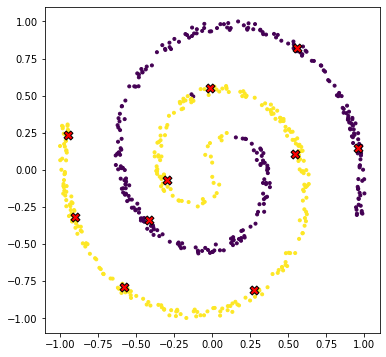

Epoch: 6099, Acc:0.98, Loss:0.9308812022209167
Epoch: 6199, Acc:0.98, Loss:0.9305657148361206
Epoch: 6299, Acc:0.98, Loss:0.9309439659118652
Epoch: 6399, Acc:0.98, Loss:0.9316610097885132
Epoch: 6499, Acc:0.98, Loss:0.9303752779960632
Epoch: 6599, Acc:0.98, Loss:0.9308254718780518
Epoch: 6699, Acc:0.98, Loss:0.9307481050491333
Epoch: 6799, Acc:0.98, Loss:0.9319506883621216
Epoch: 6899, Acc:0.98, Loss:0.9309675693511963
Epoch: 6999, Acc:0.98, Loss:0.9306387901306152


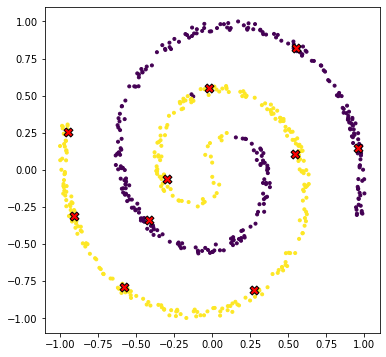

Epoch: 7099, Acc:0.98, Loss:0.9309424757957458
Epoch: 7199, Acc:0.98, Loss:0.9306514263153076
Epoch: 7299, Acc:0.98, Loss:0.9306498765945435
Epoch: 7399, Acc:0.98, Loss:0.930598258972168
Epoch: 7499, Acc:0.98, Loss:0.9365896582603455
Epoch: 7599, Acc:0.99, Loss:0.9126101732254028
Epoch: 7699, Acc:0.99, Loss:0.9094923138618469
Epoch: 7799, Acc:0.99, Loss:0.9078497886657715
Epoch: 7899, Acc:0.99, Loss:0.9073596596717834
Epoch: 7999, Acc:0.99, Loss:0.9066402912139893


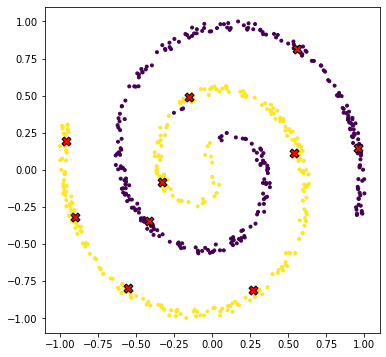

Epoch: 8099, Acc:0.99, Loss:0.9064629673957825
Epoch: 8199, Acc:0.99, Loss:0.9062454104423523
Epoch: 8299, Acc:0.99, Loss:0.9057897925376892
Epoch: 8399, Acc:0.99, Loss:0.9058213829994202
Epoch: 8499, Acc:0.99, Loss:0.9059257507324219
Epoch: 8599, Acc:0.99, Loss:0.9054848551750183
Epoch: 8699, Acc:0.99, Loss:0.9055250883102417
Epoch: 8799, Acc:0.99, Loss:0.9134693145751953
Epoch: 8899, Acc:0.99, Loss:0.9006440043449402
Epoch: 8999, Acc:0.99, Loss:0.8989863395690918


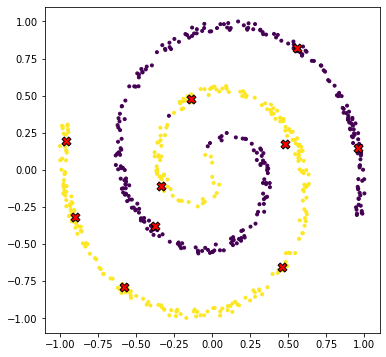

Epoch: 9099, Acc:0.99, Loss:0.8987832069396973
Epoch: 9199, Acc:0.99, Loss:0.8980927467346191
Epoch: 9299, Acc:0.99, Loss:0.8980220556259155
Epoch: 9399, Acc:0.99, Loss:0.8977781534194946
Epoch: 9499, Acc:0.99, Loss:0.8976137638092041
Epoch: 9599, Acc:0.99, Loss:0.8972312211990356
Epoch: 9699, Acc:0.99, Loss:0.8973166942596436
Epoch: 9799, Acc:0.99, Loss:0.8969345092773438
Epoch: 9899, Acc:0.99, Loss:0.9079166054725647
Epoch: 9999, Acc:0.99, Loss:0.8987799882888794


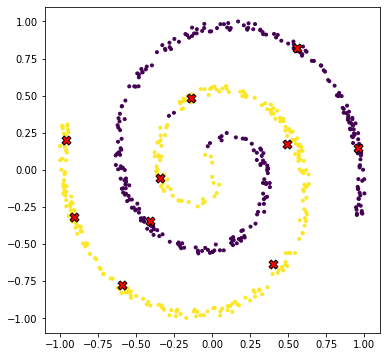

In [250]:
for epoch in range(10000):
#     wnorm = torch.norm(net.net[-1].weight.data, dim=0, keepdim=True)
#     net.net[-1].weight.data *= wnorm.clamp(0.01, 2.0)/wnorm
    
    yout = net(xx)
    loss = criterion(yout, yy)

    loss += net.get_pointwise_residual_loss(xx)*1.0
    loss += net.get_pointwise_centeroid_loss(xx)*1.0
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()    
#         accuracy = (torch.argmax(yout, dim=1).type(torch.float32) == yy).type(torch.float).mean()           
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
#         out = torch.argmax(yout, dim=1).data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], facecolor='red', marker= 'X', edgecolor='k', s=80)
        plt.show()

In [251]:
net.get_pointwise_centeroid_loss(xx), net.get_pointwise_residual_loss(xx)

(tensor(0.4459, grad_fn=<MeanBackward0>),
 tensor(0.4348, grad_fn=<MeanBackward0>))

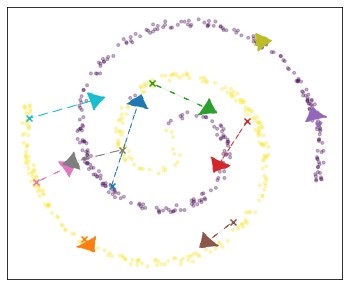

In [252]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

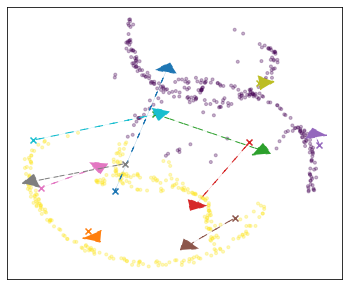

In [253]:
dev = (xx+net.net(xx)*1.0).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 #+ net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()

In [ ]:
## Using only